---
title: "Online beta estimation with the Kalman Filter"
author: "Alejandro Pérez Sanjuán"
date: 2021-08-15
categories: [finance, python, tracking, bayes, filtering]
format: html
---

In this post we briefly review the Kalman Filter and we use it to compute the beta between 2 stock returns using Python, though the procedure can also be used in many other fields with an appropiate translation.

In [1]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [2]:
# dependencies we are going to need
import investpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kalmanfilter import KalmanFilter
from sklearn.linear_model import LinearRegression

In [3]:
#hide
plt.rcParams["font.family"] = "Times New Roman"

> **DISCLAIMER: the code to generate the scatter plots was taken from Quantopian Kalman Filter notebook [1]**


## Introduction
The Kalman Filter is an optimal estimation algorithm capable of finding the true state of a signal given that this signal is noisy and/or incomplete. There are many applications where the Kalman filter is an appropiate tool; in this post we see how we can mix the Kalman filter with a linear regression to dynamically compute the beta between 2 stocks.


## Brief review
The Kalman assumes a dynamic linear system given by two equations
$$
\begin{matrix}
x_{k} = A_{k} x_{k} + B u_{k} + q_{k} \\
z_{k} = H_{k} x_{k} + r_{k}
\end{matrix}
$$

The first equation determines the expression that gives the true state of the system. The second equation tells us that any observation $z$ at time $k$ can be expressed as a linear combination of the state $x_{k}$ using the observation model $H_{k}$ plus some noise $r_{k}$.

The Kalman Filter estimates the true estate using a feedback control-loop of 2 stages: predict and update.

1. **Predict step**
$$
\begin{matrix}
\hat{x}_{k}^{-} = A_{k} \hat{x}_{k-1}^{-} + B_{k} u_{k-1} \\
P_{k}^{-} = A_{k}P_{k-1}A_{k}^{T} + Q_{k}
\end{matrix}
$$

2. **Update step**
$$
\begin{matrix}
K_k = P_{k}^{-} H_{k}^{T} (H_{k} P_{k}^{-} H_{k}^{T} + R_{k})^{-1} \\
\hat{x}_{k} = \hat{x}_{k}^{-} + K_k (z_k - H_{k} \hat{x}_{k}^{-}) \\
P_k = (I - K_k H) P_{k}^{-}
\end{matrix}
$$

We won't cover the mathematical derivation of the filter since it is very complex and it would only add useless noise to the post, but you can read it at [3] and [4].


## Linear regression & Kalman filtering
Recall the typical linear regression equation
$$
\hat{Y} = \hat{\beta}_{0} + \sum_{j=0}^{p} X_{j} \hat{\beta}_{j}
$$ 

which is equivalent to 
$$
\hat{Y} = X^{T} \hat{\beta}
$$ 

if we include the constant variable 1 in $X$, include $\hat{\beta}_{0}$ in the vector of coefficients $\hat{\beta}$ and then write the linear model in vector form as an inner product, where $X^{T}$ denotes vector or matrix transpose ($X$ is a column vector) [5].

For two dimensions, we can express the above formula as
$$
\hat{Y} = (1, x_{j})\begin{pmatrix} \hat{\beta}_{0} \\ \hat{\beta}_{1} \end{pmatrix}
$$ 

The equation above is similar to the observation equation of the Kalman Filter $z_{k} = H_{k} x_{k} + r_{k}$ and so we can write the following expression
$$
z_{k} = (1, H_{k})\begin{pmatrix} x_{k,0} \\ x_{k,1} \end{pmatrix} + r_{k}
$$

This is telling us that we can plug one stock in the $z_{k}$ and the other in the $H_{k}$ to compute a dynamic beta between both stocks. $x_{k,0}$ would be our alpha and $x_{k,1}$ our beta.

## The code
We first download the stock prices of `Amazon` and `Microsoft` and compute their arithmetic relative returns. We use arithmetic returns because of the difference in scale of absolute returns.

In [4]:
#collapse-hide
amazon = investpy.get_stock_historical_data(
    stock='AMZN',
    country='United States',
    from_date='01/01/1910',
    to_date='28/08/2021'
)


microsoft = investpy.get_stock_historical_data(
    stock='MSFT',
    country='United States',
    from_date='01/01/1910',
    to_date='28/08/2021'
)

ama_returns = amazon['Close'].pct_change()
mic_returns = microsoft['Close'].pct_change()

prices = pd.concat([amazon['Close'], microsoft['Close']], axis=1).dropna()
prices.columns = ['Amazon', 'Microsoft']

returns = pd.concat([ama_returns, mic_returns], axis=1).dropna()
returns.columns = ['Amazon', 'Microsoft']

Let's take a minute to check the data we are working with. The plot below shows 3 things:
1. The returns of one stock agains the returns of the other by period, with a regression line computed with the whole period.
2. The returns of both stocks.
3. The log prices of both stocks. I took the log for comparative purposes only.

We can clearly see that a regression line fitted on the whole data is not a good model for all periods. This is one of the main weaknesses of linear models like the Capital Asset Pricing Model (CAPM).

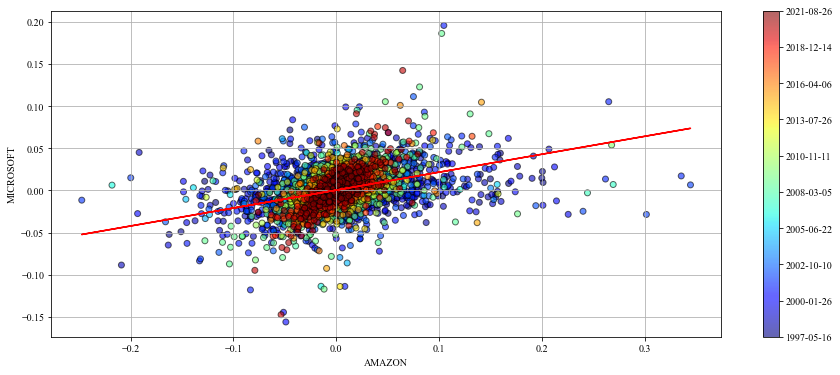

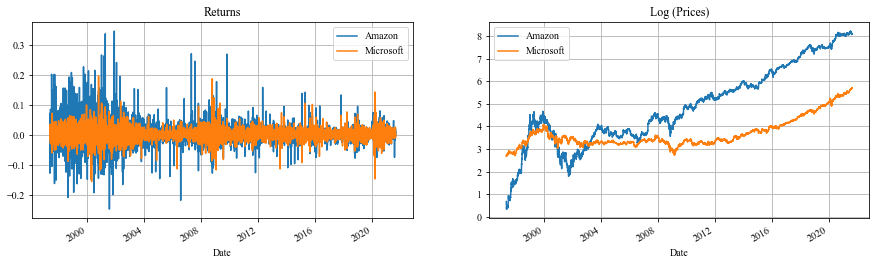

In [5]:
#collapse-hide
# linear model
regression = LinearRegression()
regression.fit(X=returns['Amazon'].values.reshape(-1,1), y=returns['Microsoft'])
y_pred = regression.predict(returns['Amazon'].values.reshape(-1,1))

# code taken from [1]
plt.figure(figsize=(15,6))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(returns))
sc = plt.scatter(returns['Amazon'], returns['Microsoft'], c=colors, cmap=cm, edgecolor='k', alpha=0.6)
plt.plot(returns['Amazon'].values, y_pred, color='red', label='Regression Line')
cb = plt.colorbar(sc)

cb.ax.set_yticklabels([str(p.date()) for p in returns[::len(returns) // 9].index])
plt.xlabel('AMAZON');
plt.ylabel('MICROSOFT');
plt.grid();
plt.show()

# ---------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4));

returns.plot(ax=ax[0])
ax[0].grid();
ax[0].set_title('Returns');
ax[0].legend()

np.log(prices).plot(ax=ax[1])
ax[1].grid();
ax[1].set_title('Log (Prices)');
ax[1].legend();

Now it is time to use the Kalman Filter. I've created [my own Kalman library](https://github.com/Xylambda/kalmanfilter) and that is what I am going to use. It is a multidimensional implementation, so we need to be careful when setting all the parameters.

Since we want to estimate not only the beta but the alpha (intercept) too, we have to work in a 2-dimensional space; and that must hold **for each time step**.

Let's set the parameters 1 by 1, starting with the state transition model $A$. 

The state transition model $A$ relates the state at the previous time step $k-1$ to the state at the current step $k$. Since stock returns can be considered random walks, $A$ should be set to be the identity in order to model a martingale process. Notice how we create a 2x2 matrix for each time step.

In [6]:
stock_a = returns['Amazon'].values
stock_b = returns['Microsoft'].values

n_steps = len(stock_a)

A = np.array([np.eye(2)] * n_steps)

Next, the control part. We are not going to use it, so we set everything to zero but taking into account the matrix dimensions we talked about earlier.

In [7]:
B = np.zeros((n_steps, 2, 2)) # model
U = np.zeros((n_steps, 2, 1)) # vector

We continue the filter design by looking at the initial estimates. The Kalman must start somewhere and we are in charge of defining that place. We assume the initial mean estimates as zero, both for alpha and beta, and the initial covariance estimates as 1, also both for alpha and beta.

In [8]:
xk = np.array([0, 0]) # initial mean
Pk = np.ones((2, 2)) # initial covariance

To continue, we define the observed variable $Z$ and the observation model $H$. The observed variable is the stock *a* (we could also choose the stock *b*).

The observation matrix relates the state to the measurement $z_{k}$. Remember the equation $z_{k} = H_{k} x_{k} + r_{k}$? By setting the $H_{k}$ to be stock b at time $k$ we have a nice linear regression; we just have to add ones to account for the intercept.

> It does not matter if we stack the ones before or after, we would just need to take care of selecting the right series after computing everything.

In [9]:
Z = stock_a.copy()
H = np.expand_dims(np.vstack([[stock_b], [np.ones(len(stock_b))]]).T, axis=1)

Lastly, we define the noises $Q$ and $R$. Given that we fixed the observation covariance to be one, the smaller is $Q$ the slower the beta will change. Notice how we are making $Q$ a diagonal matrix for each time step.

There is no need to put special shape in $R$ since we want to add 1 in each time step for all elements and NumPy will take care of the broadcasting, but we may need to check the dimensions in other cases.

In [10]:
Q = np.array([1e-3 * np.eye(2)] * n_steps) # process noise / transition covariance
R = np.ones(n_steps) # measurement noise / observation covariance

It is time to run the filter. The library works by passing all the parameters except $Z$ and $U$ to the constructor and later use the `filter` method with $Z$ and $U$ to get the estimated means and covariances.

In [11]:
kf = KalmanFilter(A=A, xk=xk, B=B, Pk=Pk, H=H, Q=Q, R=R)
states, errors = kf.filter(Z=Z, U=U)

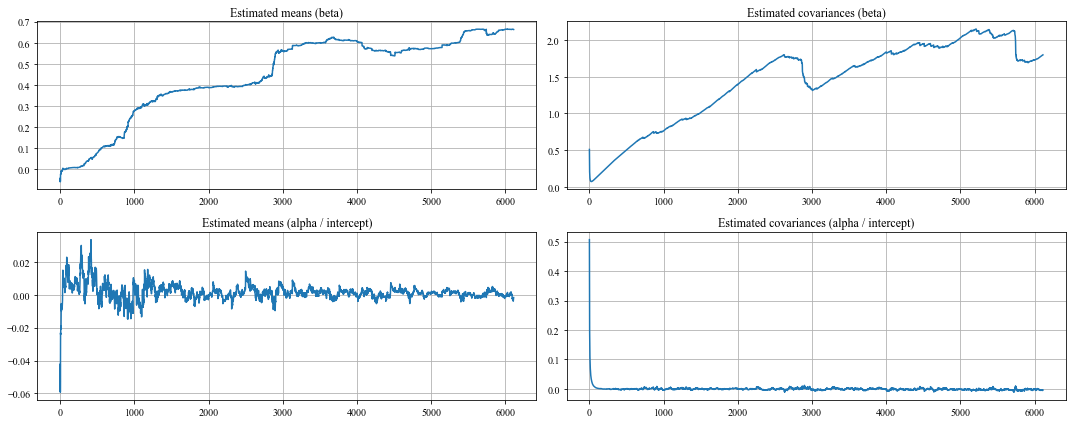

In [13]:
#collapse-hide
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

ax[0][0].plot(states[:, 0])
ax[0][0].set_title('Estimated means (beta)')
ax[0][0].grid()

ax[1][0].plot(states[:, 1])
ax[1][0].set_title('Estimated means (alpha / intercept)')
ax[1][0].grid()

ax[0][1].plot(errors[:, 0])
ax[0][1].set_title('Estimated covariances (beta)')
ax[0][1].grid()

ax[1][1].plot(errors[:, 1])
ax[1][1].set_title('Estimated covariances (alpha / intercept)')
ax[1][1].grid()

plt.tight_layout()

## What's next?
Now you can use the estimated betas and alphas to perform a linear regression in an online fashion, updating the prior knowledge recursively with the observed variable.

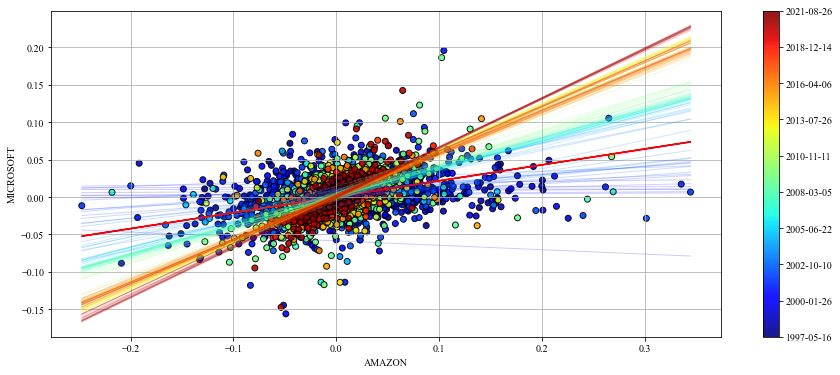

In [14]:
#collapse-hide
# code taken from [1]
plt.figure(figsize=(15,6))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(returns))
sc = plt.scatter(returns['Amazon'], returns['Microsoft'], c=colors, cmap=cm, edgecolor='k', alpha=0.9)
plt.plot(returns['Amazon'].values, y_pred, color='red', label='Regression Line')
cb = plt.colorbar(sc)


step = 50
space = np.linspace(returns['Amazon'].min(), returns['Amazon'].max(), 2)
colors_l = np.linspace(0.1, 1, len(states[::step]))
for i, beta in enumerate(states[::step]):
    plt.plot(space, beta[0] * space + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

cb.ax.set_yticklabels([str(p.date()) for p in returns[::len(returns) // 9].index])
plt.xlabel('AMAZON');
plt.ylabel('MICROSOFT');
plt.grid();
plt.show()

The dynamic beta and alpha provide a linear regression that adapts dynamically each time step. The regression line we created earlier is provided in **red** to compare. This looks much better!


## Conclusion
In this post we've seen how to perform online linear regression using the Kalman filter. The results are more realistic than a simple linear regression since they are computed updating prior distributions with new information.

One of the main drawbacks of the Kalman filter is that the assumptions of normality and linearity must hold in order for the filter to give us the optimal estimate [3].

Overall, it is a very powerful and elegant technique that seems to outperform other models, like CAPM.


## References
* [1] Quantopian - [Kalman Filters](https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Kalman_Filters/notebook.ipynb)

* [2] Quantdare - [The Kalman Filter](https://quantdare.com/the-kalman-filter/)

* [3] Thrun, S., Burgard, W., & Fox, D. (2006). Probabilistic robotics. Kybernetes.

* [4] Kevin P. Murphy - Machine Learning: A probabilistic perspective.

* [5] Jerome H. Friedman, Robert Tibshirani & Trevor Hastie - The Elements of Statistical Learning.